In [569]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [570]:
# Functions to compute alpha and beta
def alpha(u, P):
    if u == 1:
        return np.sqrt(1/P)
    else:
        return np.sqrt(2/P)

def beta(v, Q):
    if v == 1:
        return np.sqrt(1/Q)
    else:
        return np.sqrt(2/Q)

In [571]:
# Function to get the basis chip
def get_basis_chip(u, v, P=8, Q=8):
    # Compute alpha and beta
    a_u = alpha(u, P)
    b_v = beta(v, Q)
    
    # Create empty basis chip
    basis_chip = np.zeros((P, Q))
    
    # Calculate the basis chip
    for x in range(1, P+1):
        for y in range(1, Q+1):
            basis_chip[y-1, x-1] = a_u * b_v * np.cos(np.pi * (2 * x - 1) * (u - 1) / (2 * P)) * np.cos(np.pi * (2 * y - 1) * (v - 1) / (2 * Q))
    
    # Return the basis chip with the right orientation
    return basis_chip[::-1]

In [572]:
# Function to calculate convert basis chip into basis vector
def get_basis_vector_matrix(K=8):
    num_basis_vectors = K**2
    
    # Initialize the 64x64 basis vector matrix
    basis_vector_matrix = np.zeros((num_basis_vectors, num_basis_vectors))
    
    # Get all basis chips and rasterize them into column vectors
    index = 0
    for u in range(1, K + 1):
        for v in range(1, K + 1):
            # Get the basis chip
            basis_chip = get_basis_chip(u, v, P=K, Q=K)
            
            # Rasterize the basis chip into a column vector
            basis_vector_matrix[:, index] = basis_chip.flatten(order='F')
            index += 1
    
    return basis_vector_matrix

In [573]:
# Generate the 8x8 corrupted image block (chip)
def generate_corrupted(S=30, block_size=8, block=None):
    # Generate the mask
    total_pixels = block_size * block_size
    indices = np.random.choice(total_pixels, S, replace=False)
    
    # Normalize the grayscale block to the range 0–255
    block_normalized = (block - block.min()) / (block.max() - block.min()) * 255
    block_normalized = block_normalized.astype(np.uint8)

    # Generate a mask and set missing pixel intensities to NaN
    mask = np.zeros((block_size, block_size), dtype=bool)
    for index in indices:
        row, col = divmod(index, block_size)
        mask[row, col] = True
    
    # Sets corrupted pixels to NaN
    nan_block = block.astype(float)
    nan_block[~mask] = np.nan
    
    return nan_block, mask
    

In [574]:
def display_top_10_basis_chips(kappa_est):
    # Get indices of the 10 largest magnitude weights
    top_10_indices = np.argsort(np.abs(kappa_est))[-10:]
    top_10_weights = kappa_est[top_10_indices]

    # Determine u and v values
    u_values = top_10_indices // 8 + 1
    v_values = top_10_indices % 8 + 1

    # Plot the 10 basis chips
    fig, axes = plt.subplots(2, 5, figsize=(15, 5))
    fig.suptitle("Top 10 Basis Chips with Highest Weights")

    for i, ax in enumerate(axes.flatten()):
        u, v, weight = u_values[i], v_values[i], top_10_weights[i]
        basis_chip = get_basis_chip(u, v, P=8, Q=8)

        ax.imshow(basis_chip, cmap="gray")
        ax.set_title(f"(u, v) = ({u}, {v}), w={weight:.3f}")
        ax.axis("off")

    plt.show()

In [575]:
def apply_lasso_reconstruction(B, block, mask, alpha=0.01):
    # Flatten block and mask
    C = block.flatten(order='F')
    sampling_mask = mask.flatten(order='F')

    # Create A and D matrices
    D = C[sampling_mask]
    A = B[sampling_mask, :]

    # Apply LASSO regression
    lasso = Lasso(alpha=alpha, fit_intercept=True)
    lasso.fit(A, D)
    kappa_est = lasso.coef_
    intercept = lasso.intercept_

    # Reconstruct image chip
    C_hat = B @ kappa_est + intercept
    C_hat = C_hat.reshape(8, 8, order='F')

    return C_hat, kappa_est


In [576]:
# Load image
image_path = '../data/fishing_boat.bmp'
image = Image.open(image_path).convert('L')

# Convert the image to a numpy array
image_array = np.array(image)

In [577]:
# Display the 8x8 block with the top-left pixel at (x, y) = (x*, y*)
x_star = 8 * (4-1) + 1
y_star = 8 * (2-1) + 1

# Get the 8x8 block
block_size = 8
x_start = x_star - 1
y_start = y_star - 1

# Get the block end coordinates
x_end = min(x_start + block_size, image_array.shape[0])
y_end = min(y_start + block_size, image_array.shape[1])

# Gets the 8x8 block
block = image_array[x_start:x_end, y_start:y_end]

In [578]:
# Generate the 8x8 corrupted image block (chip)
S = 30
corrupted_block, mask = generate_corrupted(S, block_size=8, block=block)

In [579]:
# Compute the basis vector matrix (B)
B = get_basis_vector_matrix(K=8)

# Apply LASSO reconstruction
alpha = 0.01
reconstructed_block, kappa_est = apply_lasso_reconstruction(B, block, mask, alpha=alpha)

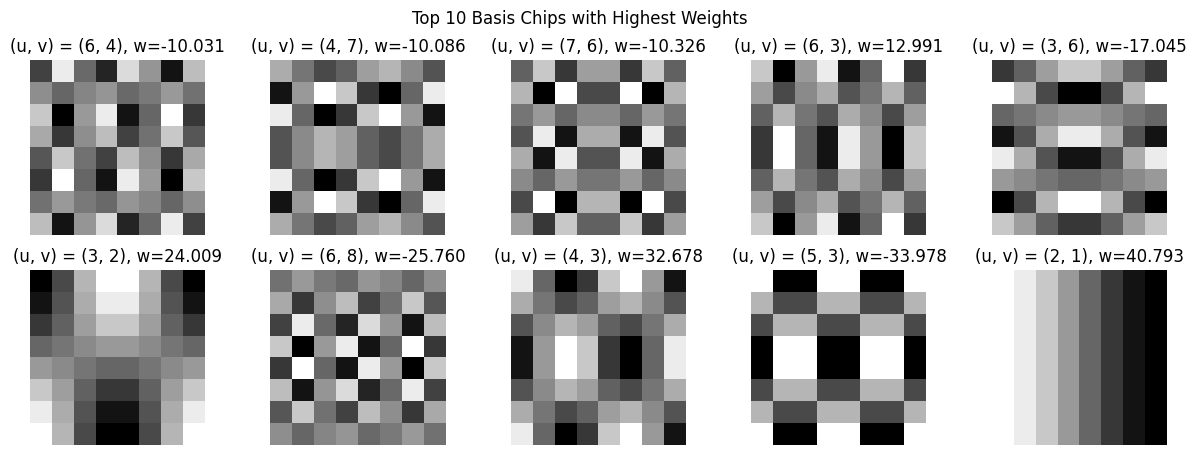

In [580]:
display_top_10_basis_chips(kappa_est)

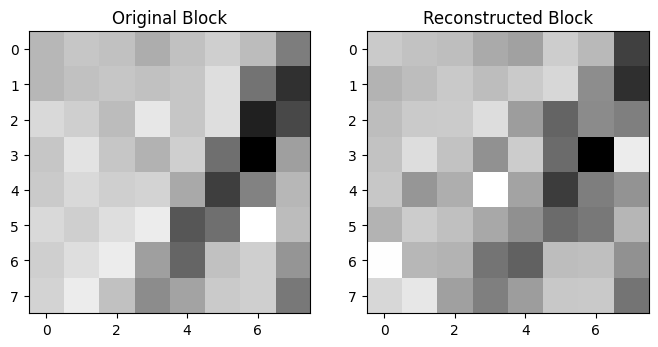

In [581]:
# Display Original vs Reconstructed
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(block, cmap='gray')
ax[0].set_title("Original Block")
ax[1].imshow(reconstructed_block, cmap='gray')
ax[1].set_title("Reconstructed Block")
plt.show()

In [582]:
# Compute Mean Squared Error (MSE)
mse = mean_squared_error(block.flatten(order='F'), reconstructed_block.flatten(order='F'))

# Print the MSE
print(f"Mean Squared Error (MSE) between original and reconstructed image chip: {mse:.4f}")

Mean Squared Error (MSE) between original and reconstructed image chip: 59.4402
